In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix,classification_report

In [2]:
def data_spliting(data,label):
    split1=StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=42)
    training_indx,temp_indx=next(split1.split(data,label))
    data_training=data[training_indx]
    label_training=label[training_indx]
    temp_data=data[temp_indx]
    temp_label=label[temp_indx]
    split2=StratifiedShuffleSplit(n_splits=1,test_size=0.5,random_state=42)
    validation_indx,testing_indx=next(split2.split(temp_data,temp_label))
    data_validation=temp_data[validation_indx]
    label_validation=temp_label[validation_indx]
    data_testing=temp_data[testing_indx]
    label_testing=temp_label[testing_indx]
    return data_training,label_training,data_validation,label_validation,data_testing,label_testing

### Implement the Gaussian Generative Classifier

In [3]:
class ProbabilisticGaussianGenerativeClassifier:
    def __init__(self):
        self.class_priors=None
        self.class_means=None
        self.class_covariances=None
        self.classes=None
        self.log_det_cov =None
        self.inv_covariances=None
        self.eps=1e-12 #tiny constant to avoid log(0) or division by zero
        self.reg_lambda=1e-4
    
    def compute_priors_means_covariances(self,data,labels):
        n_samples,n_features=data.shape
        self.classes=np.unique(labels)
        n_classes=len(self.classes)
        priors=np.zeros(n_classes,dtype=np.float64)
        means=np.zeros((n_classes,n_features),dtype=np.float64)
        for indx,class_label in enumerate(self.classes):
            class_data=data[labels==class_label] #select samples that belong to class_label
            priors[indx]=class_data.shape[0]/n_samples
            means[indx]=np.mean(class_data,axis=0)
        covariances=np.zeros((n_features,n_features),dtype=np.float64)
        for indx in range(n_classes):
            class_indx=int(np.where(self.classes==labels[indx])[0][0])
            diff=(data[indx]-means[class_indx]).reshape(-1,1) #(X-mu)
            covariances+=diff @ diff.T
        covariances/=n_samples
        ## Regularization by adding a small value to the diagonal elements to prevent singularity(non-invertible matrix)
        cov_reg=covariances + self.reg_lambda * np.eye(n_features)

        try:
            inv_covariances=np.linalg.inv(cov_reg)
        except np.linalg.LinAlgError:
            inv_covariances=np.linalg.pinv(cov_reg)
        sign, logdet = np.linalg.slogdet(cov_reg)
        if sign <= 0:
            logdet = np.log(np.abs(np.linalg.det(cov_reg)) + self.eps)
    
        self.class_priors=priors
        self.class_means=means
        self.class_covariances=cov_reg
        self.inv_covariances=inv_covariances
        self.log_det_cov=float(logdet)
        return self
    
    def log_gaussian(self,data,mean):
        diff=(data-mean).reshape(-1,1)
        mahal_term=diff.T @ self.inv_covariances @ diff
        return -0.5*(self.log_det_cov + mahal_term)
     
    
    def predict(self,data):
        n_samples=data.shape[0]
        scores=np.zeros((n_samples,len(self.classes)),dtype=np.float64)
        for i,data_point in enumerate(data):
            for j,class_label in enumerate(self.classes):
                log_likelihood=self.log_gaussian(data_point,self.class_means[j])
                log_prior=np.log(self.class_priors[j]+self.eps)
                scores[i,j]=log_likelihood.item() + log_prior.item()
        index_max=np.argmax(scores,axis=1)
        return self.classes[index_max]
    
    def predict_probalities(self,data):
        n_samples=data.shape[0]
        probabilities=np.zeros((n_samples,len(self.classes)),dtype=np.float64)#predicted probabilities for each class for that sample
        for i,data_point in enumerate(data):
            sample=np.zeros((len(self.classes),),dtype=np.float64)
            for j,class_label in enumerate(self.classes):
                sample[j]=np.log(self.class_priors[j]+self.eps) + self.log_gaussian(data_point,self.class_means[j])#log P(y=c) + log P(X|y=c)
            
            exp_x=np.exp(sample - np.max(sample))
            probabilities[i]=exp_x/(self.eps +np.sum(exp_x)) 
        return probabilities


### Loading Dataset and scaling

In [4]:
digits=load_digits()
data=digits.data
label=digits.target
data_training,label_training,data_validation,label_validation,data_testing,label_testing=data_spliting(data,label)

scaler=StandardScaler()
scaled_data_training=scaler.fit_transform(data_training)
scaled_data_validation=scaler.transform(data_validation)
scaled_data_testing=scaler.transform(data_testing)


### Hyperparameter Tuning and Evaluation

In [5]:
def tuning_lambda(training_data,training_labels,validation_data,validation_labels,lambda_values):
    results=[]
    for lamb in lambda_values:
        model=ProbabilisticGaussianGenerativeClassifier()
        model.reg_lambda=lamb
        model.compute_priors_means_covariances(training_data,training_labels)
        predictions=model.predict(validation_data)
        accuracy=accuracy_score(validation_labels,predictions)
        results.append((lamb,accuracy))
        print(f"Lambda: {lamb}, Validation Accuracy: {accuracy}")
    return results

lambdas = [1e-4, 1e-3, 1e-2, 1e-1,1,10]
tuning_results = tuning_lambda(scaled_data_training, label_training, scaled_data_validation, label_validation, lambdas)
best_lambda = max(tuning_results, key=lambda x: x[1])[0]
print(f"Best lambda selected: {best_lambda}")


Lambda: 0.0001, Validation Accuracy: 0.825925925925926
Lambda: 0.001, Validation Accuracy: 0.837037037037037
Lambda: 0.01, Validation Accuracy: 0.8444444444444444
Lambda: 0.1, Validation Accuracy: 0.8555555555555555
Lambda: 1, Validation Accuracy: 0.8444444444444444
Lambda: 10, Validation Accuracy: 0.8407407407407408
Best lambda selected: 0.1


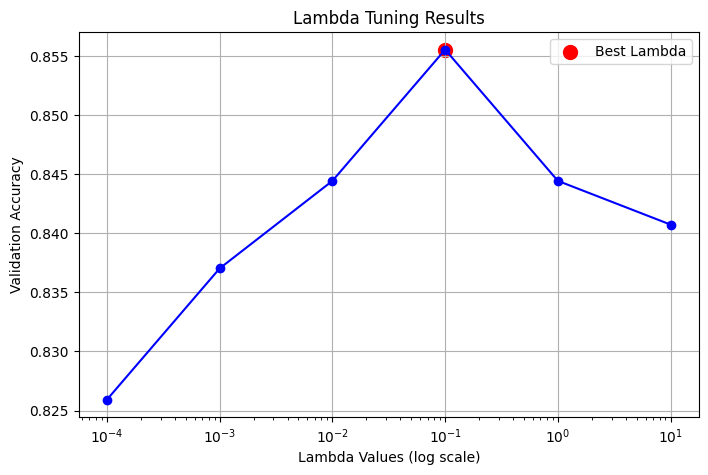

In [6]:
lambda_values=[x[0]for x in tuning_results]
accuracies=[x[1]for x in tuning_results]
plt.figure(figsize=(8,5))
plt.plot(lambda_values,accuracies,marker='o',linestyle='-',color='b')
plt.xscale('log')

best_idx=accuracies.index(max(accuracies))
plt.scatter(lambda_values[best_idx],accuracies[best_idx],color='r',s=100,label='Best Lambda')
plt.xlabel('Lambda Values (log scale)')
plt.ylabel('Validation Accuracy')
plt.title('Lambda Tuning Results')
plt.grid(True)
plt.legend()
plt.show()

### Retrain with best λ 

Testing Set Performance:
Accuracy: 0.9074074074074074
Precision: 0.9095365588373117
Recall: 0.9074074074074074
F1-Score: 0.9069283224659348


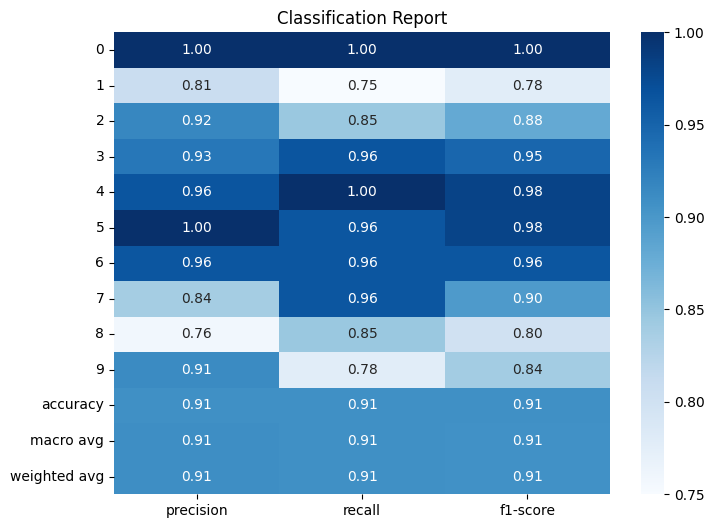

In [7]:
data_final_training=np.vstack([scaled_data_training,scaled_data_validation])
label_final_training=np.hstack([label_training,label_validation])

final_model=ProbabilisticGaussianGenerativeClassifier()
final_model.reg_lambda=best_lambda
final_model.compute_priors_means_covariances(data_final_training,label_final_training)
label_testing_pred=final_model.predict(scaled_data_testing)

testing_accuracy=accuracy_score(label_testing,label_testing_pred)
testing_precision=precision_score(label_testing,label_testing_pred,average='weighted',zero_division=0)
testing_recall=recall_score(label_testing,label_testing_pred,average='weighted',zero_division=0)
testing_f1=f1_score(label_testing,label_testing_pred,average='weighted',zero_division=0)
print("Testing Set Performance:")
print(f"Accuracy: {testing_accuracy}")
print(f"Precision: {testing_precision}")
print(f"Recall: {testing_recall}")
print(f"F1-Score: {testing_f1}")
report=classification_report(label_testing,label_testing_pred,output_dict=True,zero_division=0)
report_df=pd.DataFrame(report).iloc[:-1,:].T
plt.figure(figsize=(8,6))
sns.heatmap(report_df,annot=True,cmap='Blues',fmt='.2f')
plt.title('Classification Report')
plt.show()

### Ploting confusion matrix

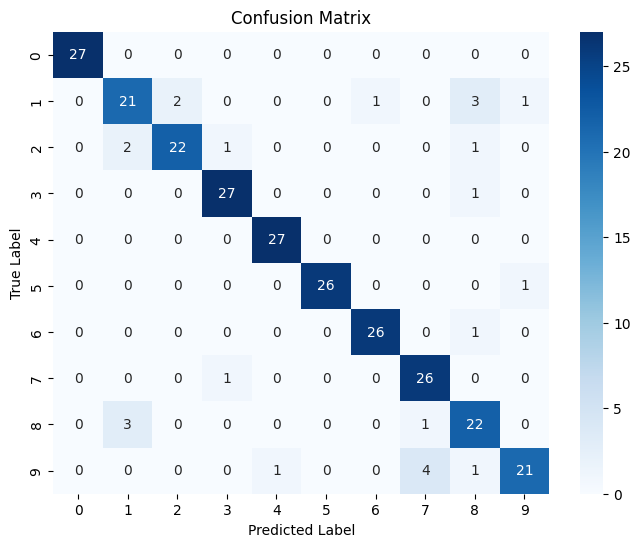

In [8]:
## plot confusion matrix
## how many samples of class i are predicted as class j
## Diagonal elements represent correct predictions
conf_matrix=confusion_matrix(label_testing,label_testing_pred)
classes=np.unique(label_testing)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=classes,yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

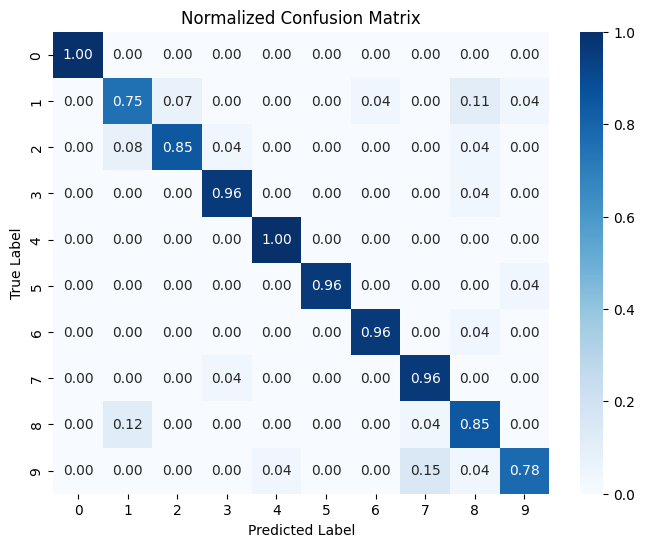

In [9]:
conf_matrix_normalized = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-12)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_normalized,annot=True,fmt='.2f',cmap='Blues',xticklabels=classes,yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

## Short explanation of the model 

### Generative model:
In this part, I used a Gaussian Generative Classifier.
I assume:

- The prior probability of each class y is p(y)=πy, where πy is estimated from class frequencies.

- The class-conditional distribution of the data is p(x∣y=k)=N(x∣μk,Σ)

meaning each class has its own mean vector μk, but all classes share the same covariance matrix.


_________________________________________________________________________________________________________

### Parameter estimation:
The parameters are estimated from the training data:
- πk = fraction of samples in class k
- μk = mean of samples in class k
- Σ= shared covariance matrix across all classes, computed as the average of 
(x−μk)(x−μk)T over all samples.

_________________________________________________________________________________________________________________________________________________________

### Regularization of covariance:
Why covariance regularization is needed

The covariance matrix can become:

- Singular (not invertible)

- Badly conditioned when features are highly correlated or the dataset is high dimensional

To fix this, we use regularization: Σλ​=Σ+λI

This shifts all eigenvalues by λ, making the matrix invertible and more stable.

Effect of λ:

- Small λ → covariance close to original, risk of numerical instability

- Large λ → covariance becomes more diagonal, model becomes simpler but may lose information

The goal is to choose λ that gives the best validation accuracy. 

_____________________________________________________________________________________

### Short discussion 

### Most commonly confused digits

From the confusion matrix, the classifier shows several consistent confusion patterns.
The most frequent misclassifications occur between digit pairs that are visually similar in handwritten form:

- 7 and 9 — these often share similar slanted upper strokes.

- 1 and 2 — many handwritten “2” examples look very close to “1”, especially when the loop is not clearly formed.

- 8 and 1 — some “8” digits with a narrow top loop resemble a tall “1”.

These confusions highlight the limitations of using a Gaussian model with a single shared covariance, which cannot easily model subtle nonlinear differences between similar digit shapes.

___________________________

### Effect of λ:
As λ increased from very small values to λ = 0.1, the validation accuracy steadily improved.
This indicates that:

- Very small λ values lead to unstable covariance estimation.

- Moderate regularization (λ = 0.1) helps stabilize the model and improves generalization.

- At larger λ values (e.g., λ = 1), performance begins to drop because the covariance becomes too regularized, pushing the model toward overly simplistic decision boundaries.

_______________________

### Strengths and Weaknesses:

Strengths:

- Fast and efficient to train.

- Requires estimating relatively few parameters.

- Performs well when classes are roughly linearly separable.

Weaknesses:

- The Gaussian assumption is not well-suited for complex digit shapes.

- Sharing one covariance matrix forces linear decision boundaries.

- Cannot model multi-modal or highly nonlinear class distributions.

As a result, while the model works reasonably well on average, it struggles with digit pairs whose handwritten forms are easily confused or highly variable.